In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import random
import glob
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2

In [2]:
tumor = []
path = "./brain_tumor_dataset/yes/*.jpg"  
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b,g,r = cv2.split(img)
    img = cv2.merge([r , g, b])
    tumor.append(img)
    
healthy = []
path = "./brain_tumor_dataset/no/*.jpg"  
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b,g,r = cv2.split(img)
    img = cv2.merge([r , g, b])
    healthy.append(img)

In [3]:
tumor = np.array(tumor)
healthy = np.array(healthy)
tumor.shape

All = np.concatenate((healthy,tumor))

Visualizing Brain MRI Images

In [4]:
def plot_random(healthy, tumor , num=5):
   healthy_imgs = healthy[np.random.choice(healthy.shape[0],num, replace=False)]
   tumor_imgs = tumor[np.random.choice(tumor.shape[0],num, replace=False)]

   plt.figure(figsize=(16,9))
   for i in range(num):
      plt.subplot(1, num , i+1)
      plt.title('healthy')
      plt.imshow(healthy_imgs[i])

   plt.figure(figsize=(16,9))
   for i in range(num):
      plt.subplot(1, num , i+1)
      plt.title('Tumor')
      plt.imshow(tumor_imgs[i])

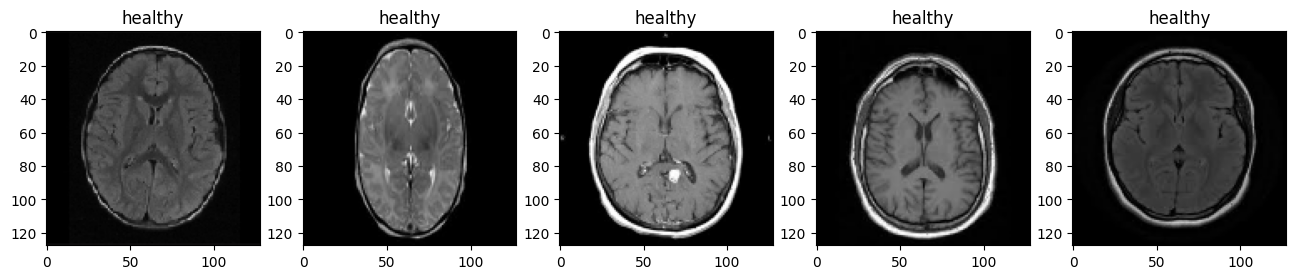

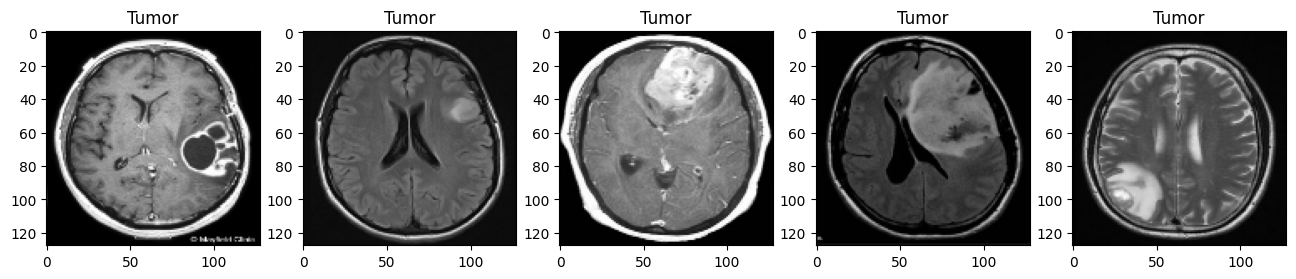

In [5]:
plot_random(healthy, tumor)

### Create Torch Dataset Class

##### Pytorch abstract dataset class

In [6]:
class Dataset(object) : 

    def __getitem__(self, index) :
        raise NotImplementedError
    
    def __len__(self) : 
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self,other])

### Creating MRI cutom dataset class

In [7]:
class MRI(Dataset):
    def __init__(self):
        tumor = []
        path = "./brain_tumor_dataset/yes/*.jpg"  
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b,g,r = cv2.split(img)
            img = cv2.merge([r , g, b])
            tumor.append(img)

        healthy = []
        path = "./brain_tumor_dataset/no/*.jpg"  
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b,g,r = cv2.split(img)
            img = cv2.merge([r , g, b])
            healthy.append(img)
        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.ones(healthy.shape[0], dtype=np.float32)

        #concatenates
        self.images = np.concatenate((tumor,healthy),axis=0)
        self.labels = np.concatenate((tumor_label,healthy_label ))
    def __getitem__(self, index):
        sample = {'image' : self.images[index], 'label':self.labels[index]}
        return sample

    def __len__(self):
        return self.images.shape[0]
    
    def normalize(self): 
        self.images = self.images/255.0

In [8]:
mri = MRI()
mri.normalize()

### Creating a dataloader

##### Without dataloader

In [9]:
index = list(range(len(mri)))
random.shuffle(index)
for idx in index :
    sample = mri[idx]
    img = sample['image']
    label = sample['label']
    # print(img.shape)
    # img = img.reshape(img.shape[2],img.shape[0], img.shape[1])
    # print(img.shape)
    # plt.title(label)
    # plt.imshow(img)
    # plt.show()

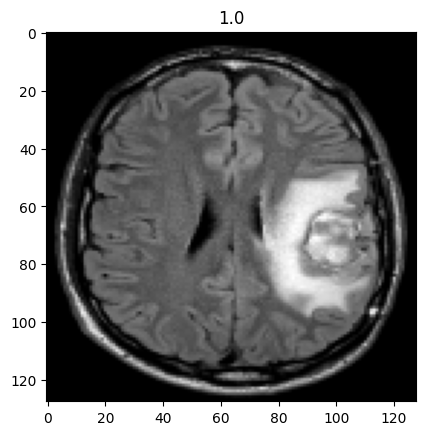

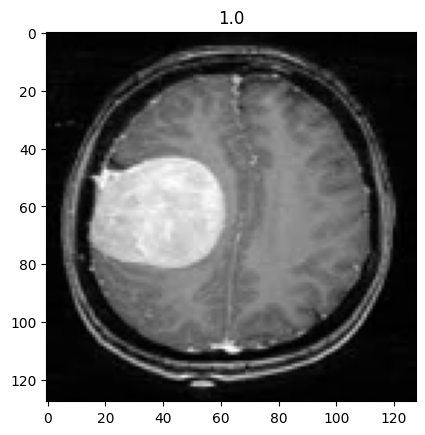

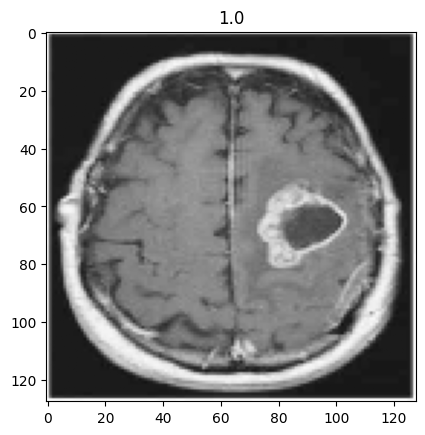

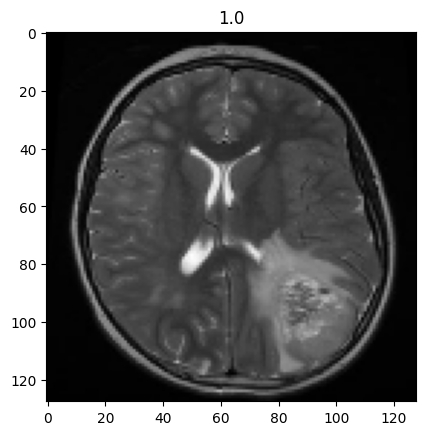

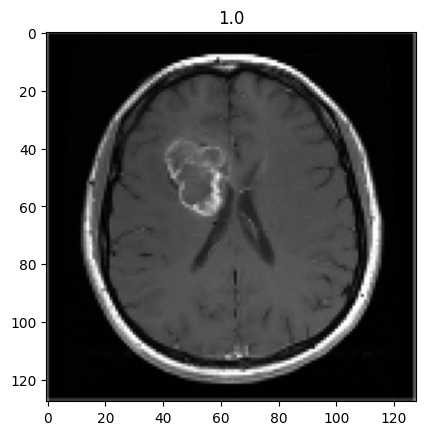

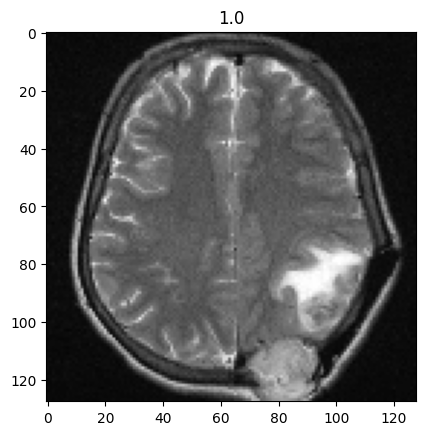

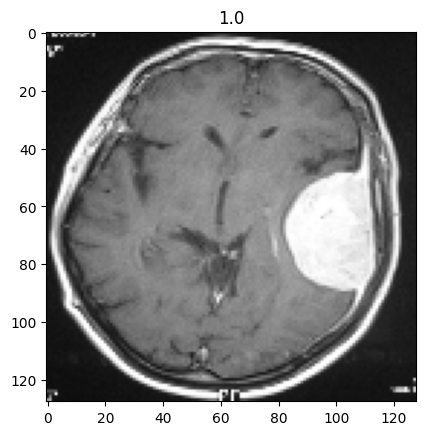

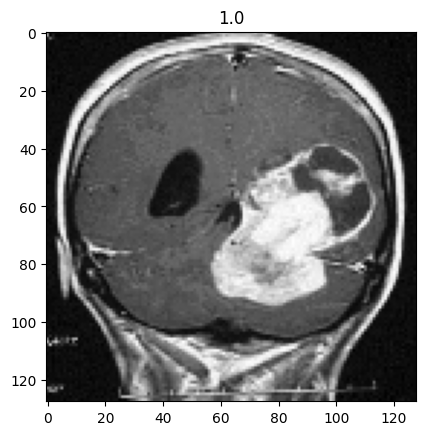

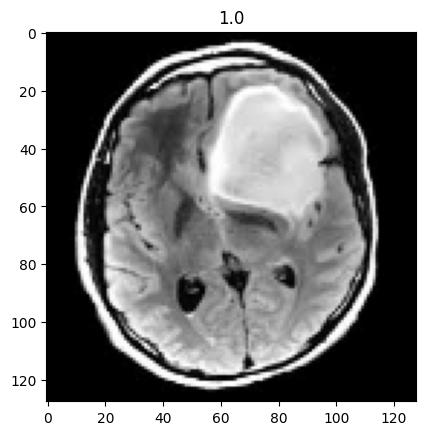

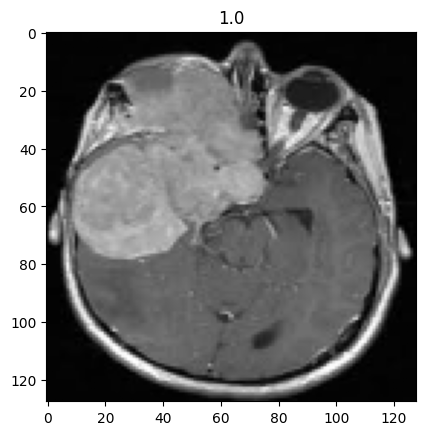

In [10]:
it = iter(mri)
for i in range(10): 
    sample = next(it)
    img = sample['image']
    label = sample['label']
    plt.title(label)
    plt.imshow(img)
    plt.show()

##### With dataloader

In [11]:
dataloader = DataLoader(mri,batch_size=10 ,shuffle=True)

In [12]:
for sample in dataloader:
    img = sample['image']
    print(img.shape)
    sys.exit()
    # plt.title(label)
    # plt.imshow(img)
    # plt.show()
    

torch.Size([10, 128, 128, 3])


SystemExit: 

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Create Model using CNN

In [ ]:
import torch.nn as nn 
import torch.nn.functional as F 

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1)
        )
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = torch.sigmoid(x)
        return x


# Basics of Training and Evaluation in Pytorch

### torch.tensor VS torch.cuda.tensor

In [ ]:
device = torch.device('cude' if torch.cuda.is_available() else 'cpu')

cpu_tensor = torch.rand(10)
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor) , cpu_tensor.type())
print(gpu_tensor , gpu_tensor.dtype , type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.3968, 0.1328, 0.7228, 0.9259, 0.3112, 0.2792, 0.6171, 0.8064, 0.8197,
        0.8203]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.3968, 0.1328, 0.7228, 0.9259, 0.3112, 0.2792, 0.6171, 0.8064, 0.8197,
        0.8203]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.1575, 0.0176, 0.5224, 0.8574, 0.0969, 0.0779, 0.3808, 0.6502, 0.6719,
        0.6729])


## Evaluate a New-Born Neural Network !

In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)


In [ ]:
dataloader = DataLoader(mri_dataset , batch_size=32 , shuffle=False)

In [ ]:
model.eval()
outputs = []
y_true = []

with torch.no_grad():
    for D in dataloader : 
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())


RuntimeError: Given groups=1, weight of size [6, 3, 5, 5], expected input[32, 128, 128, 3] to have 3 channels, but got 128 channels instead